In [231]:
from ultralytics import YOLO
from pathlib import Path
import torch
import cv2
from matplotlib import pyplot as plt
from typing import Optional
from dataclasses import dataclass


In [232]:
root = Path.cwd().parent
weights = root / "weights" / "yolov8nkaggle.pt"
data_config = root / "datasets" / "data.yaml"
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [233]:
model = YOLO(weights, task="detect")

In [234]:
names = ['Mask', 'can', 'cellphone', 'electronics', 'gbottle', 'glove', 'metal', 'misc', 'net', 'pbag', 'pbottle', 'plastic', 'rod', 'sunglasses', 'tire']
labels_mapping = dict(zip(range(len(names)), names))
labels_mapping

{0: 'Mask',
 1: 'can',
 2: 'cellphone',
 3: 'electronics',
 4: 'gbottle',
 5: 'glove',
 6: 'metal',
 7: 'misc',
 8: 'net',
 9: 'pbag',
 10: 'pbottle',
 11: 'plastic',
 12: 'rod',
 13: 'sunglasses',
 14: 'tire'}

In case of required fine-tuning

In [235]:
# Train the model
# result = model.train(data=data_config, epochs=100, imgsz=640, batch=32)

In [236]:
image_path = f'../datasets/test/images/{name}.jpg'
# Perform inference
results = model.predict(source=image_path, conf=0.5, save=True)


image 1/1 c:\Users\wojtek\Desktop\studia\semestr 3\DL\SNiUG_projekt\notebooks\..\datasets\test\images\file-20201009-15-1atu53y_jpeg_jpg.rf.3691dca4293ba92ad96095cedf156803.jpg: 640x640 1 Mask, 1 tire, 246.1ms
Speed: 21.5ms preprocess, 246.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict


In [237]:
@dataclass
class Box:
    xywh: list[float]
    label: int
    confidence: Optional[float] = None
    
    def to_bounding_box(self, scale: tuple[int, int]) -> tuple[float, float, float, float]:
        height, width = scale
        x, y, w, h = self.xywh
        
        x1, y1 = x-w/2, y-h/2
        x2, y2 = x+w/2, y+h/2
        x1 *= width
        y1 *= height
        x2 *= width
        y2 *= height
        
        return x1, y1, x2, y2


def load_image(path):
    img = cv2.imread(path)
    return img


def class_to_color(class_id):
    colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255),(255,100,100),
              (100,255,100),(100,100,255),(255,100,0),(255,0,100),(100,0,255),(100,100,255),(100,255,0),
              (100,255,100)]
    return colors[class_id]

def draw_bounding_box(img, box: Box):
    color = class_to_color(box.label)
    x1, y1, x2, y2 = map(int, box.to_bounding_box(img.shape[:2]))
    cv2.rectangle(img, pt1=(x1, y1), pt2=(x2, y2), color=color, thickness=2)

    label_text = labels_mapping[box.label]
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_thickness = 1
    text_size = cv2.getTextSize(label_text, font, font_scale, font_thickness)[0]
    text_x = x1
    text_y = y1 - 10 if y1 - 10 > 10 else y1 + 10
    text_bg_x1 = text_x
    text_bg_y1 = text_y - text_size[1]
    text_bg_x2 = text_x + text_size[0]
    text_bg_y2 = text_y + 5

    # Draw background rectangle for text
    cv2.rectangle(img, (text_bg_x1, text_bg_y1), (text_bg_x2, text_bg_y2), color, -1)
    
    # Draw text on top of the background rectangle
    cv2.putText(img, label_text, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness)

def annotate_image(img, boxes: list[Box]):
    for box in boxes:
        draw_bounding_box(img, box)
        
    return img
        

In [238]:
def plot_comparison(name: str, path: str, model: YOLO, conf: float = 0.5, save: bool = False):
    image_path = f'{path}/images/{name}.jpg'
    labels_path = f'{path}/labels/{name}.txt'
    
    results = model.predict(source=image_path, conf=conf, save=save)
    prediction_image = results[0].plot()
    
    with open(labels_path, "r") as f:
        lines = [x.strip("\n") for x in f.readlines()]
    
    boxes = []

    for line in lines:
        line = line.split(" ")
        cls_id = int(line[0])
        xywh = list(map(float, line[1:]))
        box = Box(xywh=xywh, label=cls_id)
        boxes.append(box)
    
    original_img = load_image(image_path)
    original_img = annotate_image(original_img, boxes)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    axs[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Real Bounding Boxes')
    axs[0].axis('off')
    
    axs[1].imshow(cv2.cvtColor(prediction_image, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Predicted Bounding Boxes')
    axs[1].axis('off')

    plt.show()

In [252]:
test_directory = root / "datasets" / "test"
image_directory = test_directory / "images"

names = [x.stem for x in image_directory.iterdir()]
names[:5]

['1bc7-iudfmpmn7245599_jpg.rf.c753c3518aa3bd30463da5e4b94a48be',
 '200623160205-05-coronavirus-waste-pollution-super-169_jpg.rf.e06b1a6873ec4240c3493f281822c9d9',
 '66b85ac2-5d1b-4783-b0fa-4f8adcda51a5_jpg.rf.33eb90a2198eccbfbc6e7961b953ac4a',
 '7_JPG_jpg.rf.3bf999e1c1e0a9a932b23d95b27357dc',
 'ailnlmva_jpg.rf.116e0b65179da59d199d555cb48ed605']


image 1/1 c:\Users\wojtek\Desktop\studia\semestr 3\DL\SNiUG_projekt\datasets\test\images\1bc7-iudfmpmn7245599_jpg.rf.c753c3518aa3bd30463da5e4b94a48be.jpg: 640x640 1 glove, 1 net, 173.6ms
Speed: 6.0ms preprocess, 173.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


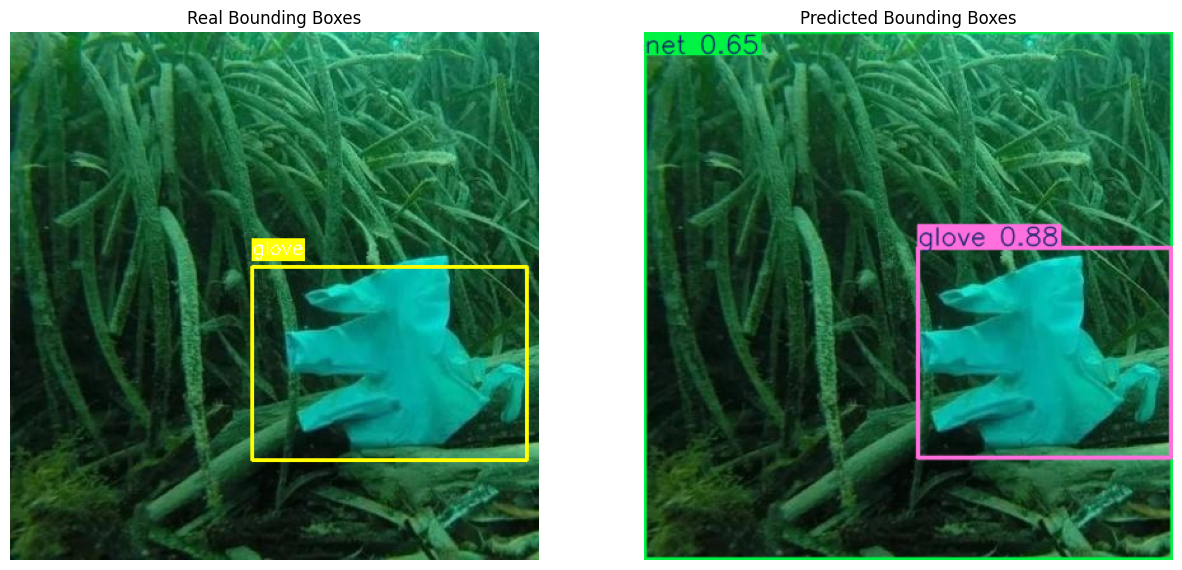


image 1/1 c:\Users\wojtek\Desktop\studia\semestr 3\DL\SNiUG_projekt\datasets\test\images\200623160205-05-coronavirus-waste-pollution-super-169_jpg.rf.e06b1a6873ec4240c3493f281822c9d9.jpg: 640x640 1 Mask, 151.2ms
Speed: 11.5ms preprocess, 151.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


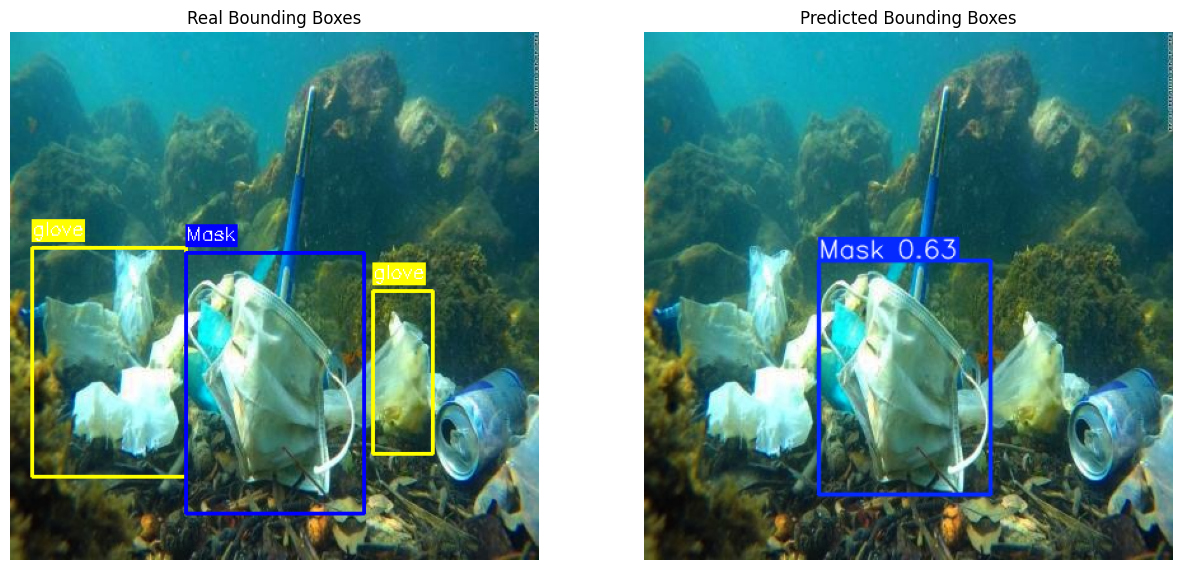


image 1/1 c:\Users\wojtek\Desktop\studia\semestr 3\DL\SNiUG_projekt\datasets\test\images\66b85ac2-5d1b-4783-b0fa-4f8adcda51a5_jpg.rf.33eb90a2198eccbfbc6e7961b953ac4a.jpg: 640x640 3 Masks, 1 plastic, 265.7ms
Speed: 1.7ms preprocess, 265.7ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


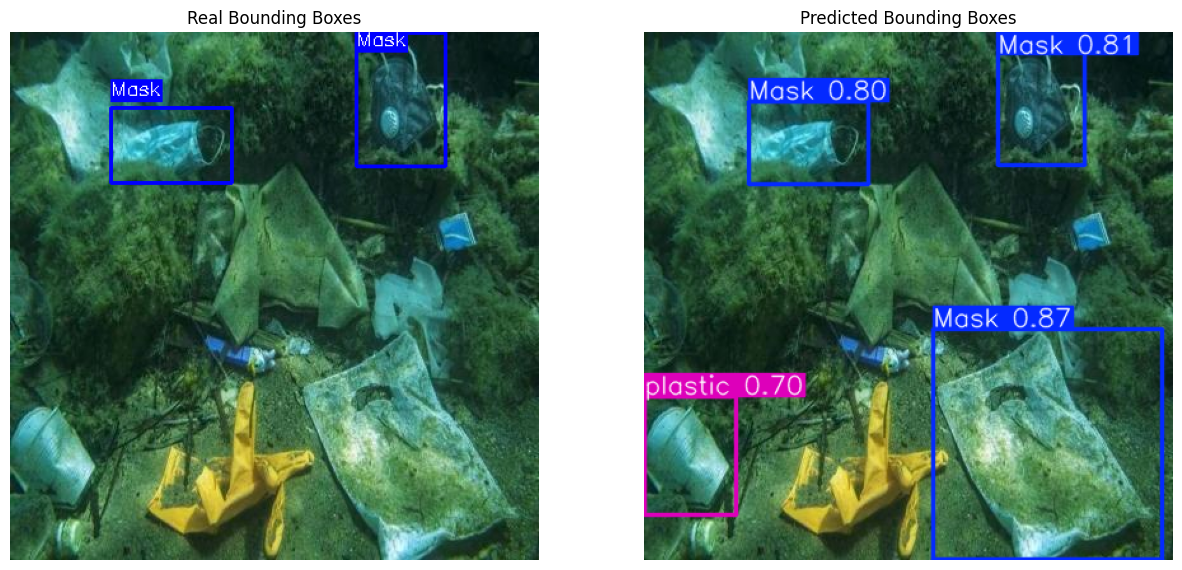


image 1/1 c:\Users\wojtek\Desktop\studia\semestr 3\DL\SNiUG_projekt\datasets\test\images\7_JPG_jpg.rf.3bf999e1c1e0a9a932b23d95b27357dc.jpg: 640x640 1 Mask, 187.2ms
Speed: 0.0ms preprocess, 187.2ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)


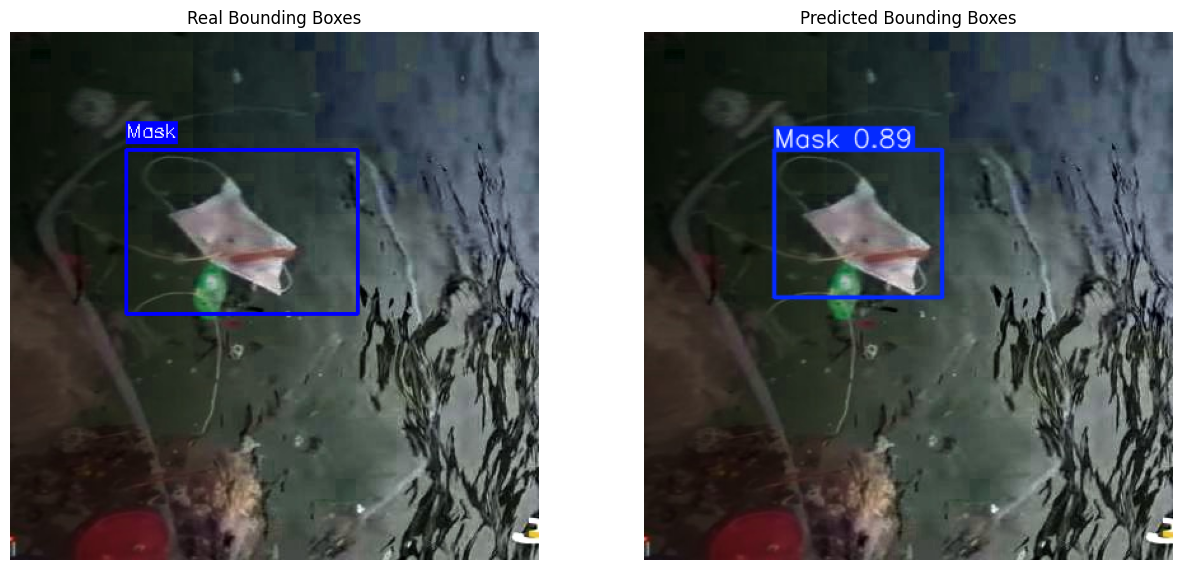


image 1/1 c:\Users\wojtek\Desktop\studia\semestr 3\DL\SNiUG_projekt\datasets\test\images\ailnlmva_jpg.rf.116e0b65179da59d199d555cb48ed605.jpg: 640x640 1 Mask, 196.8ms
Speed: 0.0ms preprocess, 196.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


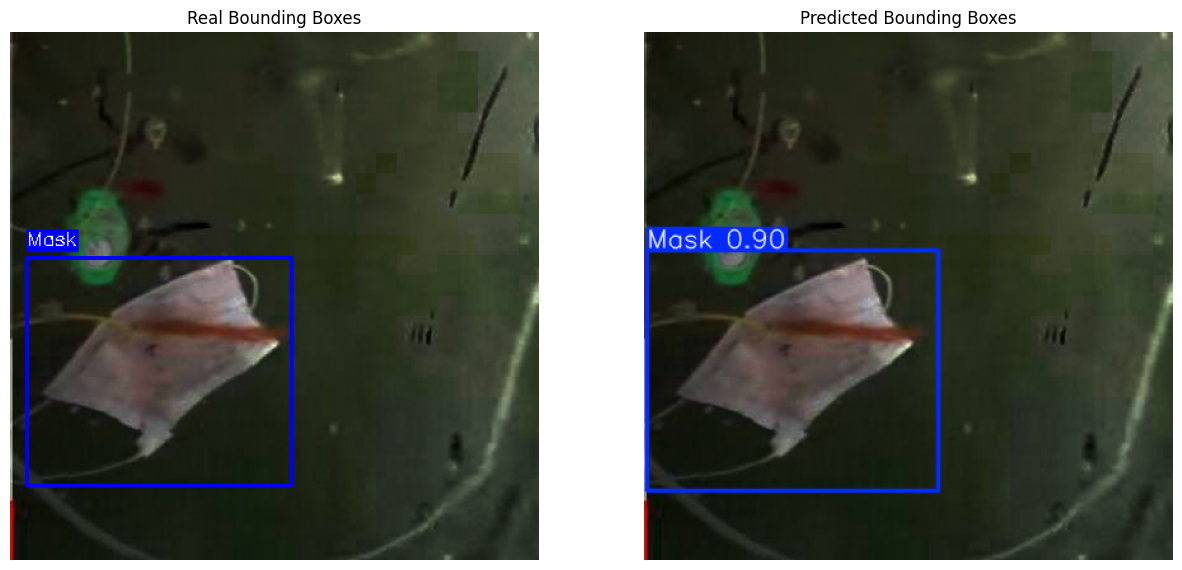

In [250]:
for name in names[:5]:
    plot_comparison(name, test_directory, model=model, conf=0.5, save=False)

In [192]:
results[0].boxes.xyxy

tensor([[156.8212, 125.1914, 335.5396, 332.4789],
        [ 88.8792, 308.8142, 375.1299, 416.0000]])

In [193]:
boxes[0].to_bounding_box(img.shape[:2])

(158.75, 125.75, 333.25, 325.25)

In [196]:
def calculate_iou(box1, box2):
    # Unpack the coordinates
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Calculate the coordinates of the intersection rectangle
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    # Calculate the area of the intersection rectangle
    inter_width = max(0, inter_x_max - inter_x_min)
    inter_height = max(0, inter_y_max - inter_y_min)
    inter_area = inter_width * inter_height

    # Calculate the area of both rectangles
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    # Calculate the IoU
    iou = inter_area / float(box1_area + box2_area - inter_area)

    return iou


calculate_iou(boxes[0].to_bounding_box(original_img.shape[:2]), results[0].boxes.xyxy[0])

0.9397140641033914